In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Prueba para conversion

In [2]:
train_conv = pd.read_pickle("../../../modelo/armado_datos/train_completo_installs")

In [3]:
train_conv["cantidad_nans"] = train_conv.isnull().sum(axis=1)

In [4]:
train_conv = train_conv[train_conv["cantidad_nans"] < 103]

In [5]:
len(train_conv)

737575

In [6]:
X, y = train_conv.drop("target",axis = 1), train_conv["target"]
X_train_conv, X_test_conv, y_train_conv, y_test_conv = \
    train_test_split(X, y, test_size=0.2, random_state=0)


In [7]:
len(y_test_conv)

147515

### Entrenamiento

In [8]:
model_conv = xgb.XGBRegressor(n_jobs=6)
model_conv.fit(X_train_conv, y_train_conv)


/home/pelozo/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:00:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=6, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [9]:
pred_conv = model_conv.predict(X_test_conv)
rmse_auctions = np.sqrt(mean_squared_error(y_test_conv, pred_conv))
print("RMSE: %f" % (rmse_auctions))

RMSE: 46595.247255


In [10]:
model_conv.save_model("modelo_conv - 001")

# Prueba para auctions

In [2]:
train_auctions = pd.read_pickle("../../../modelo/armado_datos/train_completo_auctions")

In [3]:
X, y = train_auctions.drop("target",axis = 1), train_auctions["target"]
X_train_auctions, X_test_auctions, y_train_auctions, y_test_auctions = \
    train_test_split(X, y, test_size=0.2, random_state=0)


In [4]:
len(y_test_auctions)

257209

### Entrenamiento

In [5]:
model_auctions = xgb.XGBRegressor(n_jobs=6)
model_auctions.fit(X_train_auctions, y_train_auctions)


/home/pelozo/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=6, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [7]:
pred_auctions = model_auctions.predict(X_test_auctions)
rmse_auctions = np.sqrt(mean_squared_error(y_test_auctions, pred_auctions))
print("RMSE: %f" % (rmse_auctions))

RMSE: 89293.381640


In [9]:
len(train_auctions)

1286041

In [11]:
model_auctions.save_model("modelo_auctions - 001")

---

## Predicciones

In [2]:
model_auctions = xgb.XGBRegressor()

In [3]:
model_auctions.load_model("modelo_auctions - 001")

[21:43:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [4]:
model_installs = xgb.XGBRegressor()

In [6]:
model_installs.load_model("modelo_conv - 001")

[21:43:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


---

In [7]:
features_competencia = pd.read_pickle("features_completos_competencia")

---

In [76]:
predicciones_auctions = model_auctions.predict(features_competencia)

---

In [77]:
predicciones_conversion = model_installs.predict(features_competencia)

---

In [78]:
pred_auctions = pd.DataFrame({"device_id": features_competencia.index,"predicciones":predicciones_auctions})

In [79]:
pred_conv = pd.DataFrame({"device_id": features_competencia.index, "predicciones": predicciones_conversion})

In [80]:
pred_conv["predicciones"].min()

62831.42

---

## Pongo en tres días los que no tenian datos

In [30]:
#maximo = 259200

In [28]:
#disp_sin_datos = (features_competencia[features_competencia.isnull().all(axis = 1)]).index

In [36]:
#condicion = pred_conv["device_id"].isin(disp_sin_datos)
#pred_conv.loc[condicion, "predicciones"] = maximo

#condicion = pred_auctions["device_id"].isin(disp_sin_datos)
#pred_auctions.loc[condicion, "predicciones"] = maximo


---

### Cargo archivo de submissions

In [82]:
submissions = pd.read_csv("../../../../data/tp2/target_competencia_ids.csv")

In [83]:
submissions.head()

,ref_hash,obj
0,1000169251625791246_sc,0
1,1000169251625791246_st,0
2,1000395625957344683_sc,0
3,1000395625957344683_st,0
4,1003027494996471685_sc,0


In [84]:
pred_auctions["device_id"] = pred_auctions["device_id"].apply(lambda x: str(x)+"_st")

In [85]:
pred_conv["device_id"] = pred_conv["device_id"].apply(lambda x: str(x)+"_sc")

In [86]:
q = submissions.copy()

In [87]:
rename_dict = pred_conv.set_index('device_id').to_dict()["predicciones"]

In [88]:
rename_dict_2 = pred_auctions.set_index('device_id').to_dict()['predicciones']

In [89]:
q["obj"] = q["ref_hash"]

In [90]:
q["obj"] = q["obj"].replace(rename_dict)

In [91]:
q["obj"] = q["obj"].replace(rename_dict_2)

In [92]:
 q["obj"] = q["obj"].astype(np.int64)

In [93]:
q.set_index("ref_hash").to_csv("target_con_todos_sin.csv")

In [74]:
#q.set_index("ref_hash").to_csv("target_con_todos.csv")

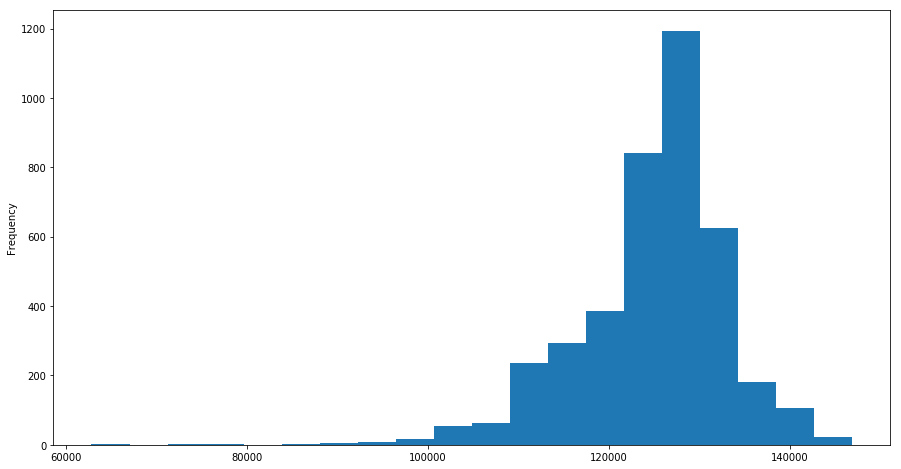

In [99]:
pred_conv["predicciones"].plot(kind = "hist", bins = 20, figsize = (15,8))

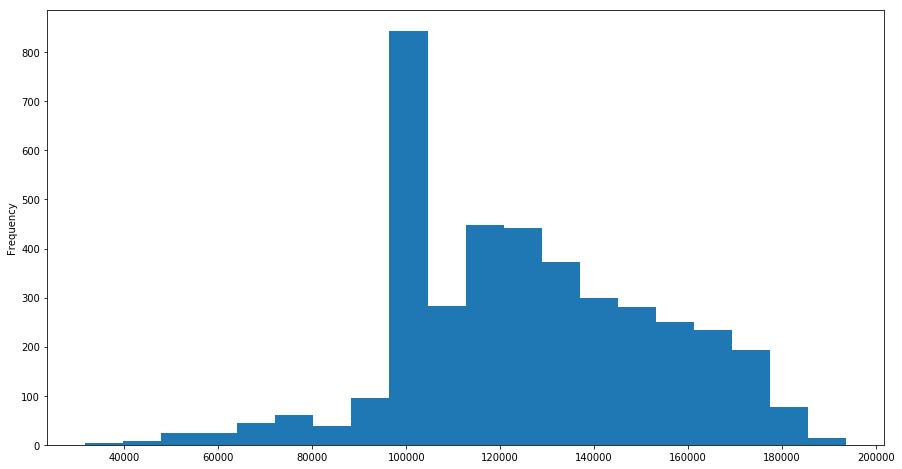

In [100]:
pred_auctions["predicciones"].plot(kind = "hist", bins = 20, figsize = (15,8))